# Import

In [46]:
## Suppress warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

## Notebook display settings
from IPython.display import display
pd.options.display.max_columns = None

## Graph modules
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from mpl_toolkits.mplot3d import Axes3D

import os.path
## Plot style
%matplotlib inline

colors = {0:'tab:blue',1:'tab:orange',2:'tab:green'}

# Data

In [47]:
with open('data.pickle', 'rb') as handle:
    data = pickle.load(handle)
data.head()

id  run               timestamp  segment          start_time  \
0  163.0  0.0 2017-05-30 09:21:13.150     11.0 2017-05-30 09:21:05   
1  164.0  0.0 2017-05-30 09:21:13.200     11.0 2017-05-30 09:21:05   
2  165.0  0.0 2017-05-30 09:21:13.250     11.0 2017-05-30 09:21:05   
3  166.0  0.0 2017-05-30 09:21:13.300     11.0 2017-05-30 09:21:05   
4  167.0  0.0 2017-05-30 09:21:13.350     11.0 2017-05-30 09:21:05   

                 end_time   force_x   force_y   force_z       pos_x  \
0 2017-05-30 09:22:41.607 -0.543045 -2.924596 -7.257000 -257.695704   
1 2017-05-30 09:22:41.607 -0.465969 -3.278856 -7.522000 -257.617629   
2 2017-05-30 09:22:41.607 -0.317475 -3.435834 -7.705999 -256.626803   
3 2017-05-30 09:22:41.607 -0.298383 -3.457754 -7.580999 -254.594017   
4 2017-05-30 09:22:41.607 -0.289898 -3.447854 -7.539000 -251.411919   

        pos_y       pos_z       rot_x       rot_y       rot_z result_robot  
0 -265.980105  240.007357   -0.008832    0.034723  179.958414      Success  
1 -265.999590  240.004745   -0.000171    0.019928  179.968161      Success  
2 -266.602650  239.791224 -179.993978  179.989304    0.164766      Success  
3 -267.926090  239.323013 -179.992478  179.999036    0.577883      Success  
4 -269.894497  238.550625 -179.996649  179.988091    1.210269      Success

## Preprocessing

In [48]:
runs = data["run"].unique()

In [49]:
split_data = []

# Da für die Bearbeitung nur die Suchen interessant sind, hier schon eine Filterung
search_list = []

for r in runs:
    df = data[data["run"]== r]
    segments = df["segment"].unique()
    count_segments = len(segments)
    count_components = int(count_segments/3)
    # print(f"{r} : {count_segments = } {count_components = } \n {segments}")
    run_data = []
    for i in range(count_components):
        move = df[df["segment"] == segments[i*3]]
        descend = df[df["segment"] == segments[i*3 + 1]]
        search = df[df["segment"] == segments[i*3 + 2]]
        component_data = [move, descend, search]
        run_data.append(component_data)
        search_list.append(search)
    split_data.append(run_data)


# Code

## Lists

Find the starting and end points for the searching segments.

In [50]:
start_points = []
end_points = []
rel_end_points = []

for r in search_list:
    x = r["pos_x"]
    y = r["pos_y"]
    z = r["pos_z"]

    point = r[["pos_x", "pos_y", "pos_z"]]

    start_idx = r["timestamp"].idxmin()
    end_idx = r["timestamp"].idxmax()

    start = point.loc[start_idx].values
    end = point.loc[end_idx].values
    # As it is more interessting to see the end point in relation to the start point the coordinates from the start get substracted.
    rel_end = end - start

    #Adding points to the lists
    start_points.append(start)
    end_points.append(end)
    rel_end_points.append(rel_end)

    dist = point.diff().fillna(0)

    # Order ist important here! For the first calculation we therefore can use the whole DataFrame without selectors.
    dist["distance"] = np.linalg.norm(dist.values,axis=1)
    dist["distance2d"] = np.linalg.norm(dist[["pos_x", "pos_y"]].values,axis=1)

start_points = pd.DataFrame(start_points, columns=["x","y","z"])
end_points = pd.DataFrame(end_points, columns=["x","y","z"])
rel_end_points = pd.DataFrame(rel_end_points, columns=["x","y","z"])

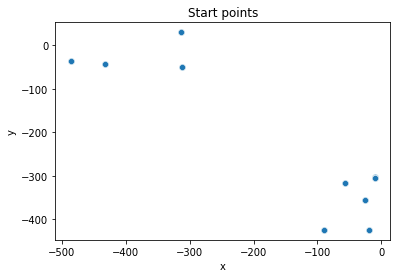

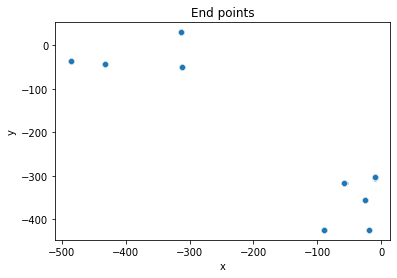

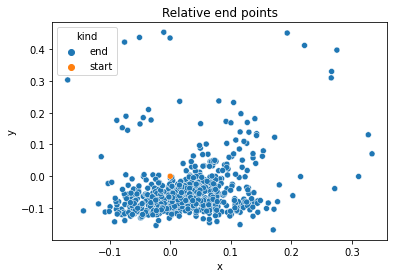

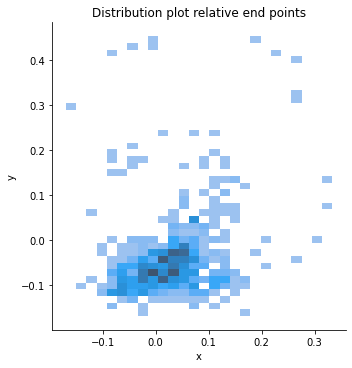

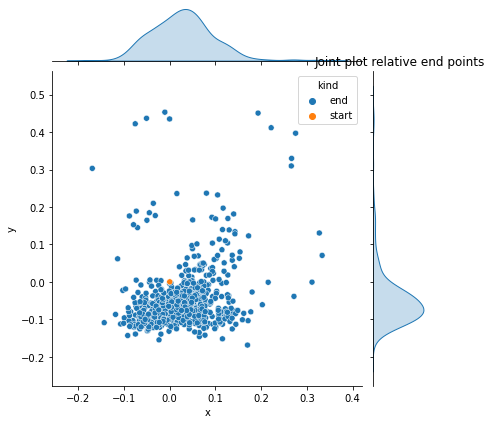

In [51]:
# Prepare data for seaborn scatterplot

# print("Start points")
sns.scatterplot(data=start_points, x="x", y="y")
plt.title("Start points")
plt.show()

#print("\nEnd points")
sns.scatterplot(data=end_points, x="x", y="y")
plt.title("End points")
plt.show()

print()
rel_plot_data = rel_end_points.copy()
rel_plot_data["kind"] = "end"
index = rel_plot_data.columns
rel_plot_data = rel_plot_data.append(pd.DataFrame([[0,0,0,"start"]], columns=index))
#print("\nRelative end points")
sns.scatterplot(data=rel_plot_data, x="x", y="y", hue="kind")
plt.title("Relative end points")
plt.show()

sns.displot(data=rel_end_points, x="x", y="y")
plt.title("Distribution plot relative end points")
plt.show()

sns.jointplot(data=rel_plot_data, x="x", y="y", hue="kind")
plt.title("Joint plot relative end points")
plt.show()

In [52]:
step_size = 0.02

x = rel_end_points["x"]
y = rel_end_points["y"]

x_min = rel_end_points["x"].min()
x_max = rel_end_points["x"].max()
y_min = rel_end_points["y"].min()
y_max = rel_end_points["y"].max()

x_ll = (x_min//step_size) * step_size
x_ul = (x_max//step_size + 2) * step_size

y_ll = (y_min//step_size) * step_size
y_ul = (y_max//step_size + 2) * step_size

x_edge = np.arange(x_ll, x_ul, step_size)
y_edge = np.arange(y_ll, y_ul, step_size)

hist, xedge, yedge = np.histogram2d(x=x, y=y, bins=(x_edge,y_edge))
filepath = os.path.join("files","hist2d_out.csv")
np.savetxt(filepath,hist,delimiter=";",fmt="%d")